Implemeting the paper arXiv:1511.06434 [DCGAN]

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio
import glob
import os
import time
from IPython import display
from tensorflow.keras import layers

Install the latest version of tensorflow 2 to run the normalize and fit functions

In [0]:
!pip install tensorflow==2.1.0-rc1
tf.__version__

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train = tf.linalg.normalize(train,axis = 1)

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

'Convolve' until the required size that is 28x28x1 is reached

In [0]:
def make_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias = False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
 
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)
  return model

In [0]:
generator = make_generator()
noise = tf.random.normal([1,100])
gen_img  = generator(noise,training = False)

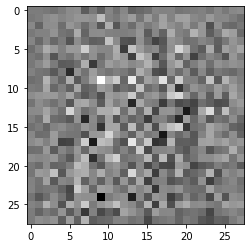

In [0]:
plt.imshow(gen_img[0,:,:,0],cmap='gray') # plotting the initial noise

In [0]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
discriminator = make_discriminator()
decision = discriminator(gen_img)
print (decision)

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # initialize the loss funtion to be used

In [0]:
def gen_loss(fake):
  loss = cross_entropy(tf.ones_like(fake),fake)
  return loss

def disc_loss(real , fake):
  loss = cross_entropy(tf.zeros_like(fake),fake) + cross_entropy(tf.ones_like(real),real)
  return loss       

In [0]:
gen_optim = tf.keras.optimizers.Adam(1e-4)
disc_optim = tf.keras.optimizers.Adam(1e-4)

In [0]:
@tf.function
def train_step(img):
    noise = tf.random.normal([BATCH_SIZE, noise = 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # generate the fake

      real = discriminator(img, training=True)  # let the discriminator do it's deed
      fake = discriminator(generated_images, training=True)

      gloss = gen_loss(fake)       # find the losses
      dloss = disc_loss(real, fake)

    grad_gen = gen_tape.gradient(gloss, generator.trainable_variables) # find the gradients
    grad_disc = disc_tape.gradient(dloss, discriminator.trainable_variables)

    gen_optim.apply_gradients(zip(grad_gen, generator.trainable_variables))   # update the generator and discriminator parameters
    disc_optim.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

In [0]:
Epochs = 20


train(train_dataset, Epochs)